In [ ]:
#import libraries
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
import csv
import numpy as np
import math

In [794]:
cities = pd.read_json("data/cities.json")
cities = cities[cities['rank'] < 21]
cities.head()

,city,growth_from_2000_to_2013,latitude,longitude,population,rank,state
0,New York,4.8%,40.712784,-74.005941,8405837,1,New York
1,Los Angeles,4.8%,34.052234,-118.243685,3884307,2,California
2,Chicago,-6.1%,41.878114,-87.629798,2718782,3,Illinois
3,Houston,11.0%,29.760427,-95.369803,2195914,4,Texas
4,Philadelphia,2.6%,39.952584,-75.165222,1553165,5,Pennsylvania


In [50]:
def search(city, state, offset):
    """Query the Search event API
    Args:
        location: city and state. 
        sort_on: Sort on distance.
        limit: Number of events results to return.
        offset: Offset the list of returned events by this amount.
    Returns:
        dict: The JSON response from the request.
    """
    # set API parameters 
    api_key = "Ddkm64oio8iDEILXcmsqJafNO28Rigf9HslqdM4nDuBnGe6D0Zic8iQxaGnJQ3ntleuyBma3Oy80E28IE2dB3PksITsPUf9MAXVsbCBv4he5cqfUpNM8MkYu172XXXYx" 
    api_host = 'https://api.yelp.com/v3/businesses/search'
    location = "{}, {}".format(city, state)
    #category = ['religiousorgs','restaurants','active','arts','beautysvc','bicycles','education','eventservices','food','hotelstravel','localflavor','nightlife','pets']
    search_limit = 50
    search_offset = offset
    prices ="1, 2, 3, 4"

    url_params = {
        'location': location,
        'sort_on': 'distance',
        'limit': search_limit,
        'offset': search_offset,
        "price": prices
    }
    
    # set header for authorization 
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
    
    # get response from API
    response = requests.request('GET', api_host, headers=headers, params=url_params)
    return response.json()


In [ ]:
"""
we are fetching the most popular 50 events for each city

"""
result = [] 
for index, row in cities.iterrows():
    for offset in [0, 51]:
        r = search(row['city'], row['state'], offset)
        # get data from response
        events = r['businesses']
        # convert from json to dataframe
        df = json_normalize(events)
        cols = ['categories', 'coordinates.latitude', 'coordinates.longitude', 'distance', 'location.city','location.state','price','rating', 'review_count', 'transactions']
        # append to final result 
        result.append(df[cols])

In [ ]:
# merge 20 responses in the list
results= pd.concat(result)
print("Shape of raw events data: {}".format(results.shape))

In [58]:
results.groupby("rating").size()

rating
3.0      2
3.5     54
4.0    915
4.5    975
5.0     54
dtype: int64

In [125]:
results.to_csv("data/data.csv", index = False)

In [796]:
# merge with categories 
cat = pd.read_json("data/categories.json")
cat = cat[['alias', 'parents', 'title']]
# Categories column is saved in a csv file as a string, 
# use literal_eval to convert it as list.
from ast import literal_eval
results = pd.read_csv("data.csv")
results['alias'] = results['categories'].map(lambda x: literal_eval(x)[0]['alias'])
results = pd.merge(results, cat, on='alias', how='left')
# merge with cities 
cities = cities[['population', 'city']]
results = pd.merge(results, cities, left_on='location.city', right_on = "city", how = "left")
cols = ['coordinates.latitude', 'coordinates.longitude',
       'distance', 'location.city', 'location.state', 'price', 'rating',
       'review_count', 'parents', 'title', 'population']
results = results[cols]
results.isnull().sum()

coordinates.latitude     0
coordinates.longitude    0
distance                 0
location.city            0
location.state           0
price                    0
rating                   0
review_count             0
parents                  0
title                    0
population               9
dtype: int64

In [797]:
results = results.rename(columns={"coordinates.latitude": "latitude", "coordinates.longitude": "longitude", 
                   "location.city": "city", "location.state": "state", "parents" : "category", "title" : "subcategory"})

In [798]:
results['category'] = results['category'].map(lambda x: x[0])
results.head()

,latitude,longitude,distance,city,state,price,rating,review_count,category,subcategory,population
0,40.777352,-73.980283,8082.367282,New York,NY,$$,4.5,8073,food,Bakeries,8405837.0
1,40.722237,-73.987430,1954.747221,New York,NY,$$,4.0,12286,restaurants,Delis,8405837.0
2,40.764770,-73.986140,6579.837043,New York,NY,$,4.0,9461,restaurants,Food Stands,8405837.0
3,40.762820,-73.985180,6427.921252,New York,NY,$,4.5,4787,food,Coffee & Tea,8405837.0
4,40.742555,-74.006084,4244.358699,New York,NY,$,4.5,2967,mexican,Tacos,8405837.0


In [799]:
results.shape

(2000, 11)

# Data Cleaning 

In [800]:
def label_price(row):
    if row == "$":
        return "cheap"
    if row == "$$":
        return "affordable"
    if row == "$$$":
        return "expensive"
    if row == "$$$$":
        return "luxury"
    return ""

results['price'] = results['price'].map(lambda x: label_price(x))
results.groupby("price").size()

price
affordable    1324
cheap          453
expensive      184
luxury          39
dtype: int64

In [801]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_palette('Set2')
import numpy as np
import pandas as pd

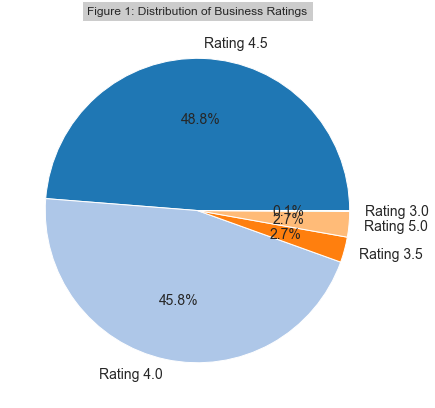

In [802]:
ratings = results['rating'].value_counts()
indexes = list(ratings.index)

labels, sizes = [], []
for i in indexes:
    label = "Rating {}".format(i)
    labels.append(label)
    sizes.append(ratings[i])
    

plt.figure(figsize=(7,7))
with plt.style.context({"axes.prop_cycle" : plt.cycler("color", plt.cm.tab20.colors)}): 
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, textprops={'fontsize': 14})
    plt.title("Figure 1: Distribution of Business Ratings", bbox={'facecolor':'0.8', 'pad':5})
    #plt.tight_layout()
    
    plt.show()

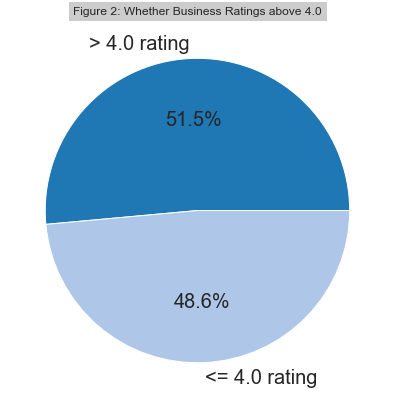

In [803]:
results['high_rating'] = results['rating'] > 4.0

ratings = results['high_rating'].value_counts()
ratings

indexes = list(ratings.index)

labels, sizes = [], []
for i in indexes:
    if i: 
        labels.append("> 4.0 rating")
    else:
        labels.append("<= 4.0 rating")
    sizes.append(ratings[i])

plt.figure(figsize=(7,7))
with plt.style.context({"axes.prop_cycle" : plt.cycler("color", plt.cm.tab20.colors)}): 
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, textprops={'fontsize': 20})
    plt.title("Figure 2: Whether Business Ratings above 4.0", bbox={'facecolor':'0.8', 'pad':5})
    plt.show()

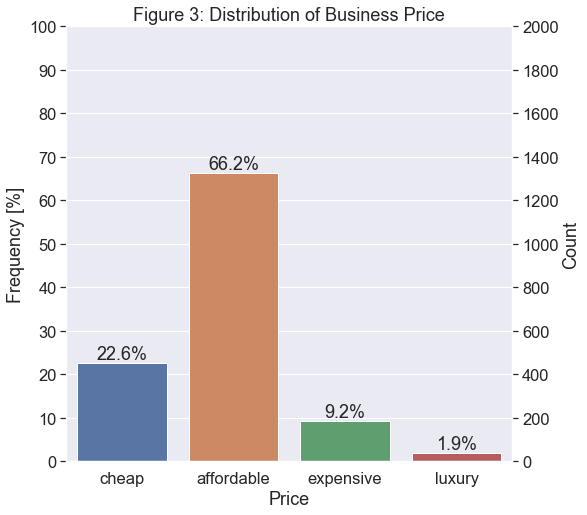

In [804]:

import matplotlib.ticker as ticker

ncount = len(results)

plt.figure(figsize=(8,8))
#sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=1.5)

ax = sns.countplot(x="price", data=results, order=['cheap', 'affordable', 'expensive', 'luxury'])
plt.title('Figure 3: Distribution of Business Price')
plt.xlabel('Price')
plt.ylabel('Count')

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

[Text(0.5, 1.0, 'Figure 3: Business Price')]

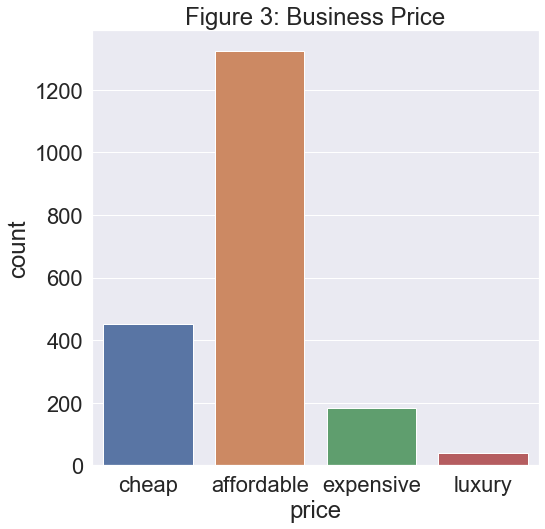

In [805]:
sns.set(rc={'figure.figsize':(8,8)})
sns.set(font_scale=2)
sns.countplot(x='price', data=results, order=['cheap', 'affordable', 'expensive', 'luxury']).set(
title = 'Figure 3: Business Price') 

/Users/zihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/zihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/zihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


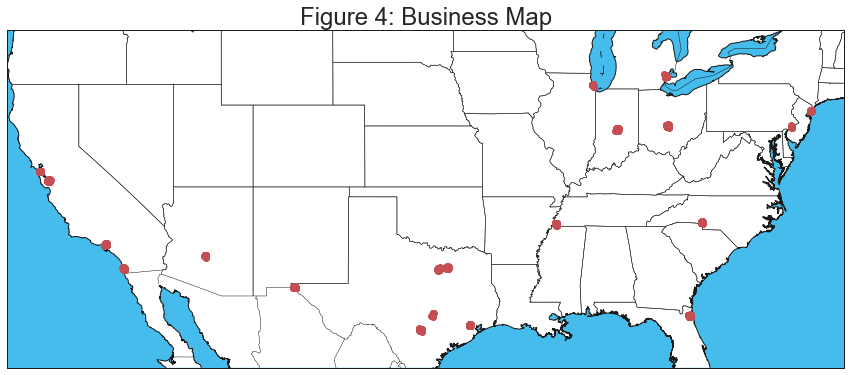

In [806]:
# long, lat, city, state
import matplotlib.pyplot as plt
# conda install basemap
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")
from mpl_toolkits.basemap import Basemap
import pandas as pd

from bokeh.plotting import figure, show
from bokeh.sampledata.us_states import data as states
from bokeh.models import ColumnDataSource, Range1d

plt.figure(figsize=(15,10))
# read in data to use for plotted points
lat = results['latitude'].values
lon = results['longitude'].values

# determine range to print based on min, max lat and lon of the data
margin = 2 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color = 'white',lake_color='#46bcec')
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = 'o', color='r', zorder=10)
plt.title("Figure 4: Business Map" )
plt.show()

/Users/zihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/zihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/zihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


<Figure size 576x576 with 0 Axes>

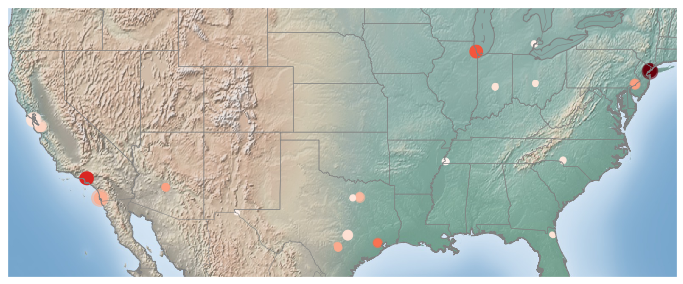

In [807]:
plt.figure(figsize=(8,8))
# Extract the data we're interested in
lat = results['latitude'].values
lon = results['longitude'].values
population = results['population'].values
area = results['review_count'].values

# 1. Draw the map background
plt.figure(figsize=(12,6))
# determine range to print based on min, max lat and lon of the data
margin = 2 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(population), s=area/50,
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
# plt.colorbar(label=r'$\log_{10}({\rm population})$')
# plt.clim(3, 7)

# # make legend with dummy points
# for a in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');


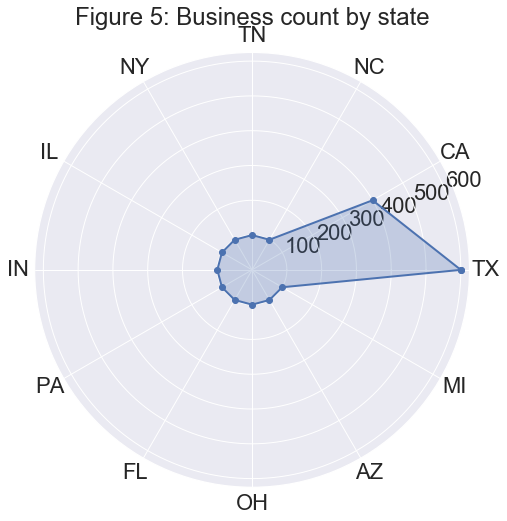

In [808]:
import numpy as np

ratings = results['state'].value_counts()
indexes = list(ratings.index)

labels, stats = [], []
for i in indexes:
    #label = "Rating {}".format(i)
    labels.append(i)
    stats.append(ratings[i])
    
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
stats=np.concatenate((stats,[stats[0]]))
angles=np.concatenate((angles,[angles[0]]))

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)   
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)

ax.set_thetagrids(angles * 180/np.pi, labels)
plt.title("Figure 5: Business count by state" )
plt.show()

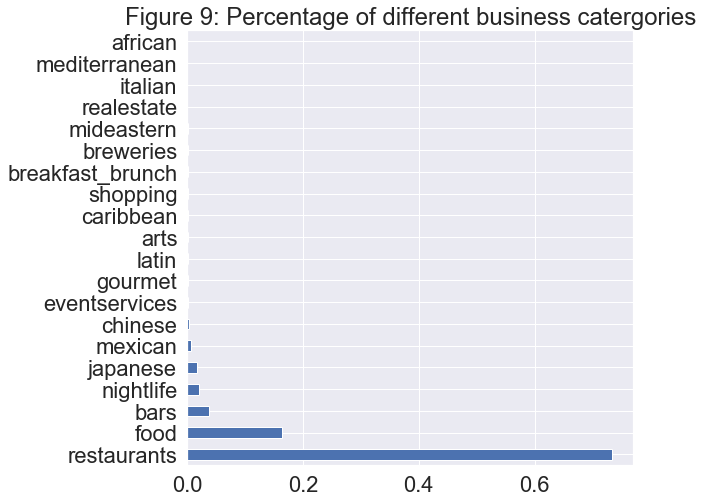

In [809]:
total = results['category'].value_counts().sum()
gp = results['category'].value_counts() / total
gp.plot(kind='barh', title = "Figure 9: Percentage of different business catergories")

Text(0, 0.5, 'Restaurant Category')

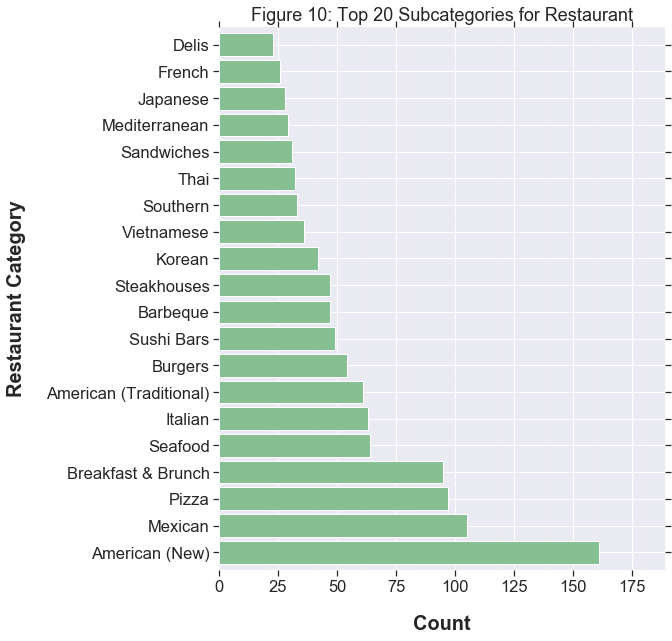

In [810]:
sub = results[results['category'] == "restaurants"]
gp = sub['subcategory'].value_counts()[:20]

sns.set(font_scale=1.5)
ax = gp.plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_title("Figure 10: Top 20 Subcategories for Restaurant")
# Set x-axis label
ax.set_xlabel("Count", labelpad=20, weight='bold', size=20)

# Set y-axis label
ax.set_ylabel("Restaurant Category", labelpad=20, weight='bold', size=20)

# Format y-axis label
# ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

[Text(0.5, 1.0, 'Figure 3: Business Price')]

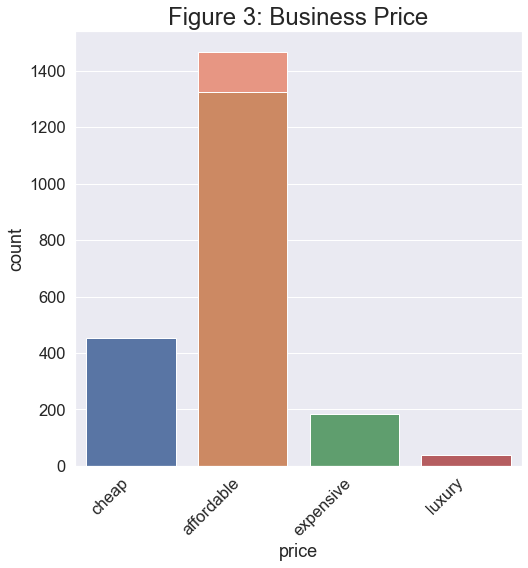

In [811]:
chart = sns.countplot(x="category", data=results, orient = "h")

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2)
sns.countplot(x='price', data=results, order=['cheap', 'affordable', 'expensive', 'luxury']).set(
title = 'Figure 3: Business Price') 

[Text(0.5, 0, 'review count'),
 Text(0.5, 1.0, 'Figure 6: Box Plot of Business Review Count')]

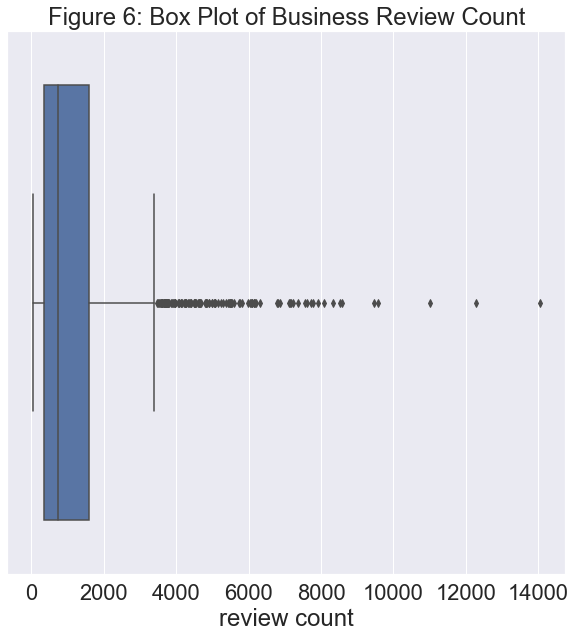

In [812]:
sns.boxplot(results['review_count']).set(title = 'Figure 6: Box Plot of Business Review Count', xlabel ="review count") 

In [813]:
df = results[results['review_count'] > 4000]
len(df)

89

[Text(0.5, 0, 'review count'),
 Text(0.5, 1.0, 'Figure 7: Businesses having less than 4000 reviews')]

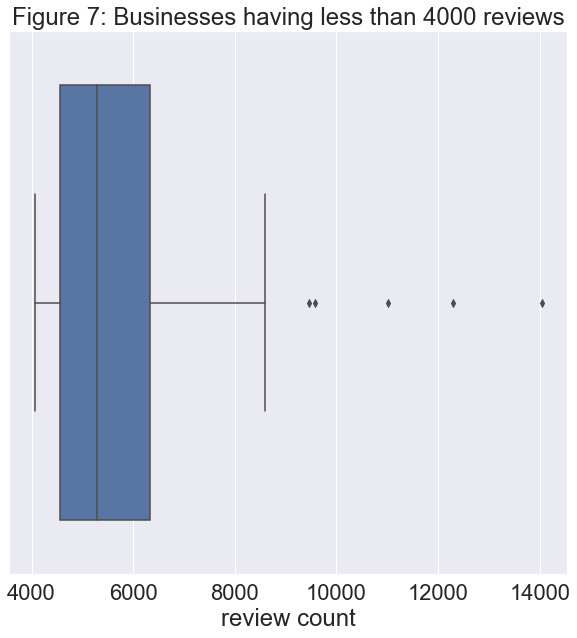

In [814]:
results = results[results['review_count'] < 4000]
sns.boxplot(df['review_count']).set(title = 'Figure 7: Businesses having less than 4000 reviews', xlabel ="review count") 

#sns.FacetGrid

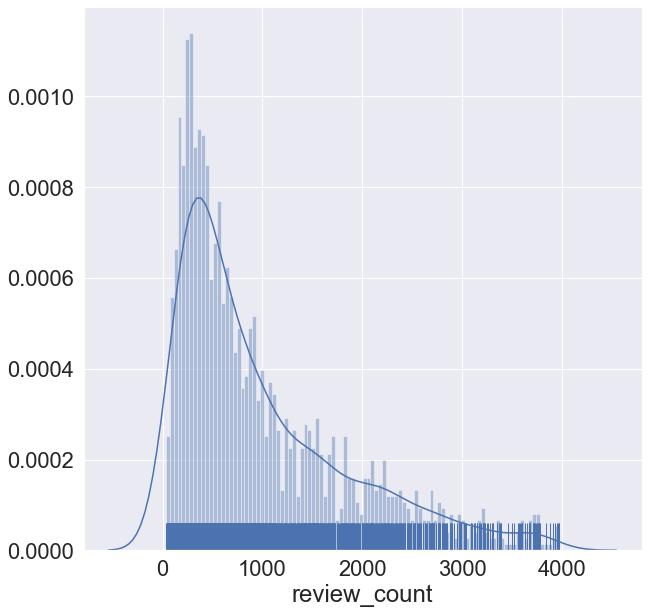

In [815]:
sns.distplot(results['review_count'], bins=100, kde=True, rug=True);

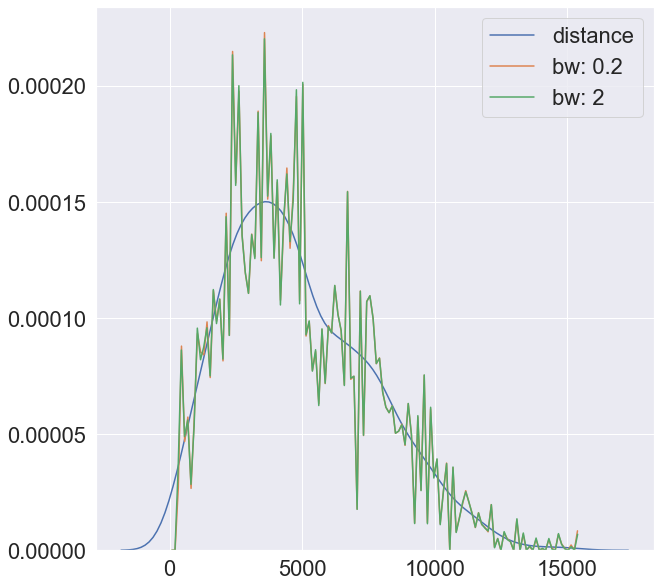

In [816]:
x = results['distance']
sns.kdeplot(x)
sns.kdeplot(x, bw=.2, label="bw: 0.2")
sns.kdeplot(x, bw=2, label="bw: 2")
plt.legend()

[Text(0.5, 0, 'Distance (meters)'),
 Text(0.5, 1.0, 'Figure 8: How far are businesses away from the city center?')]

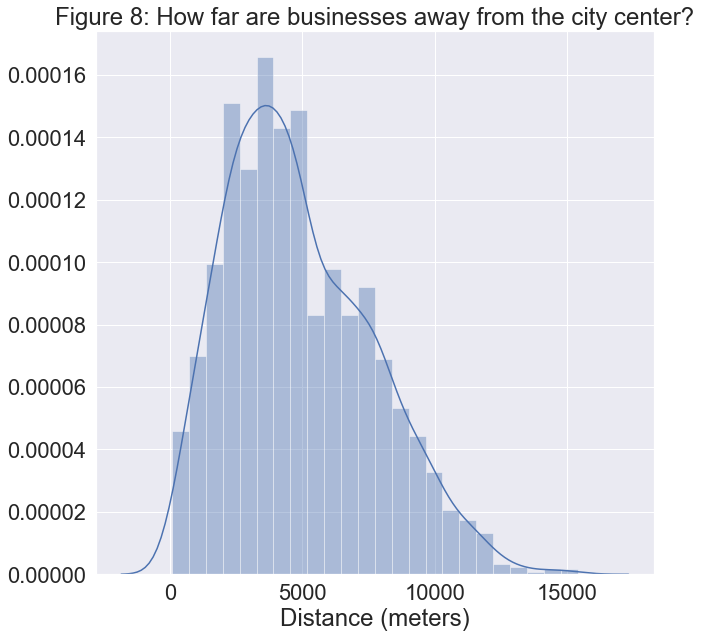

In [817]:
sns.distplot(results['distance']).set(title = 'Figure 8: How far are businesses away from the city center?', xlabel ="Distance (meters)") 

In [818]:
results.describe()

,latitude,longitude,distance,rating,review_count,population
count,1911.000000,1911.000000,1911.000000,1911.000000,1911.000000,1.904000e+03
mean,35.299804,-95.925945,4899.946070,4.263213,1000.521193,1.553425e+06
std,4.181872,14.808269,2736.152505,0.300614,869.755097,1.587445e+06
min,29.398000,-122.506090,86.248358,3.000000,31.000000,6.534500e+05
25%,31.818324,-106.501870,2750.506972,4.000000,342.500000,7.928620e+05
50%,34.091010,-95.440810,4467.736564,4.500000,688.000000,8.854000e+05
75%,39.871530,-83.043261,6728.840494,4.500000,1437.500000,1.513367e+06
max,42.444848,-73.879350,15383.122931,5.000000,3977.000000,8.405837e+06


[Text(0, 0.5, 'Population'),
 Text(0.5, 1.0, 'Figure 11: Population Distribution')]

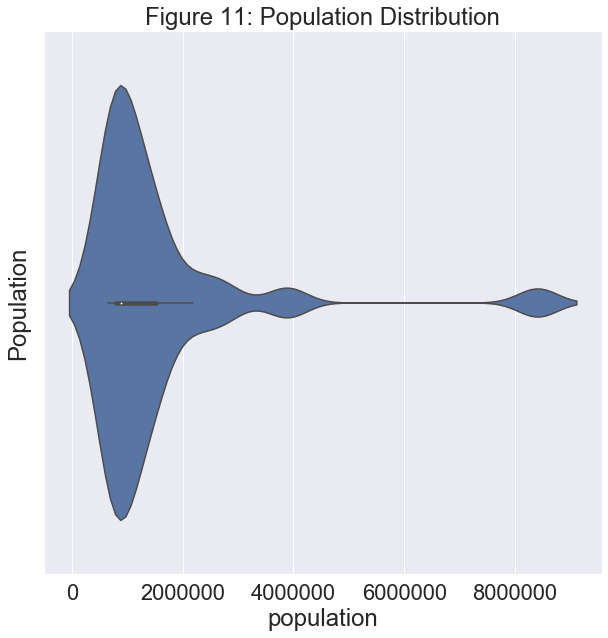

In [819]:
sns.set_style('darkgrid')
results = results.dropna(subset=['population'])
sns.violinplot(results['population']).set(title = "Figure 11: Population Distribution", ylabel = "Population")

[Text(0, 0.5, 'log(Population)'),
 Text(0.5, 1.0, 'Figure 12: Natural logarithm of Population Distribution')]

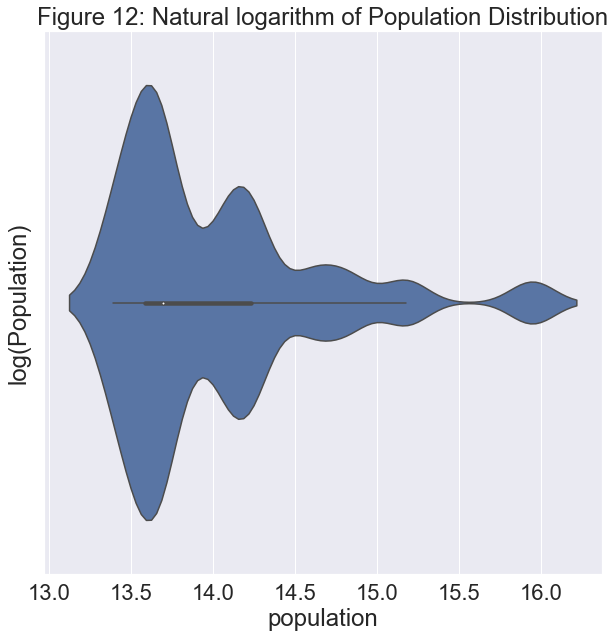

In [820]:
# Natural logarithm of
sns.violinplot(np.log(results['population'])).set(title = "Figure 12: Natural logarithm of Population Distribution", ylabel = "log(Population)")


In [821]:
results['population'] = np.log(results['population'])
results.head()

,latitude,longitude,distance,city,state,price,rating,review_count,category,subcategory,population,high_rating
4,40.742555,-74.006084,4244.358699,New York,NY,cheap,4.5,2967,mexican,Tacos,15.944437,True
5,40.722909,-73.994486,1941.963817,New York,NY,cheap,4.5,3560,restaurants,Pizza,15.944437,True
7,40.752268,-73.991086,5213.531501,New York,NY,cheap,4.5,3309,food,Bagels,15.944437,True
9,40.739020,-73.990650,3744.570400,New York,NY,affordable,4.5,3355,restaurants,Thai,15.944437,True
10,40.738440,-73.988250,3702.807580,New York,NY,luxury,4.5,2897,restaurants,American (New),15.944437,True


In [822]:
results.columns

Index(['latitude', 'longitude', 'distance', 'city', 'state', 'price', 'rating',
       'review_count', 'category', 'subcategory', 'population', 'high_rating'],
      dtype='object')

In [823]:
sub = list(results['subcategory'].value_counts()[:10].index)

In [824]:
df = results[results['subcategory'].isin(sub)]
df = pd.crosstab(df['subcategory'],df['city'])
df

city,Austin,Charlotte,Chicago,Columbus,Dallas,Detroit,El Paso,Fort Worth,Houston,Indianapolis,Jacksonville,Los Angeles,Memphis,New York,Philadelphia,Phoenix,San Antonio,San Diego,San Francisco,San Jose
subcategory,,,,,,,,,,,,,,,,,,,,
American (New),4,7,12,13,8,14,7,13,8,7,9,1,5,4,9,13,8,6,4,2
American (Traditional),3,2,3,4,6,3,4,4,2,3,2,1,8,0,3,0,3,3,2,1
Bakeries,1,1,3,3,1,3,1,1,2,2,4,1,2,5,2,2,1,2,9,8
Breakfast & Brunch,5,4,5,4,2,2,3,8,3,7,6,2,5,1,5,3,8,7,3,3
Coffee & Tea,3,3,4,5,4,2,7,4,7,5,6,3,5,1,3,12,5,1,7,4
Ice Cream & Frozen Yogurt,2,3,1,5,1,1,0,2,3,3,2,5,2,5,1,1,2,4,6,5
Italian,3,1,4,4,1,7,4,0,1,2,2,3,2,5,7,3,1,5,3,2
Mexican,3,1,3,2,6,4,17,5,3,4,3,8,2,1,3,11,11,5,2,7
Pizza,8,5,5,5,3,5,5,2,4,3,7,1,4,6,1,9,3,4,4,4


[Text(0.5, 1, 'Figure 17: Heatmap between Restaurant Categories and City')]

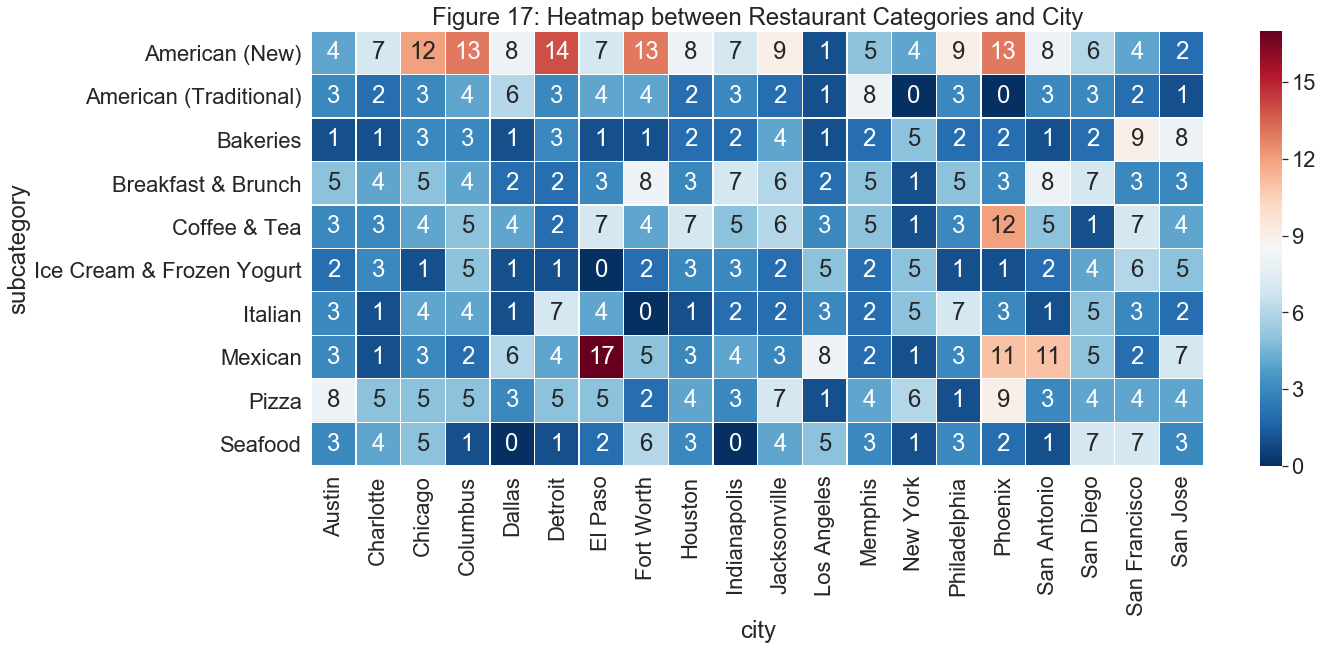

In [825]:
sns.set_context({"figure.figsize":(20,8)})
sns.heatmap(data=df, cmap="RdBu_r", annot=True,fmt="d",linewidths=0.3).set(title = "Figure 17: Heatmap between Restaurant Categories and City")

/Users/zihe/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/zihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/zihe/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

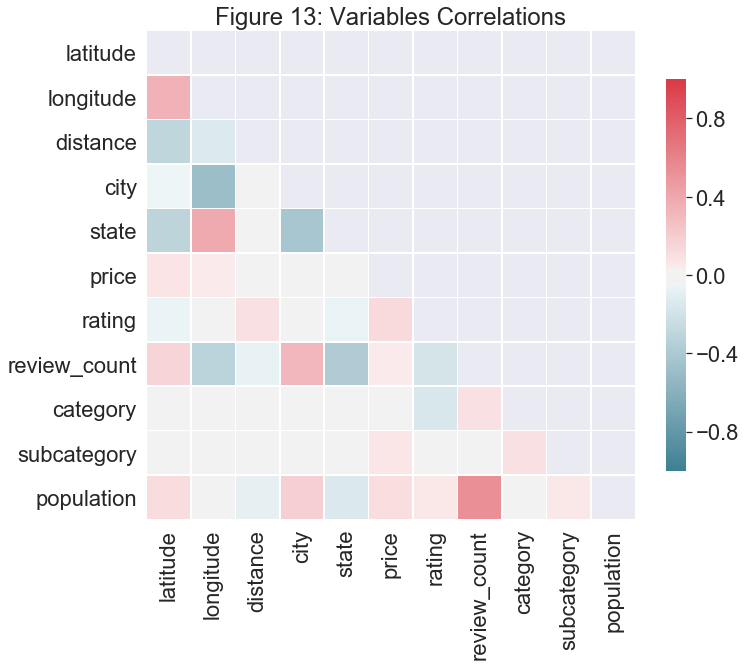

In [826]:
data = results[['latitude', 'longitude', 'distance', 'city', 'state', 'price', 'rating',
       'review_count', 'category', 'subcategory', 'population']]

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

categorical_attr = ['city', 'state', 'price', 'category', 'subcategory']
# encode categorical variables
label_encoder = LabelEncoder()
data[categorical_attr] = data[categorical_attr].apply(label_encoder.fit_transform)
# scale continuous variables based its min and max values
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])


corr = data.corr()
mask = np.zeros_like(corr)

with sns.axes_style(None):

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": 0.8}).set(title = "Figure 13: Variables Correlations")
   


[Text(0, 0.5, 'review count'),
 Text(0.5, 0, 'log(population)'),
 Text(0.5, 1.0, 'Figure 14: Linear regression model fit')]

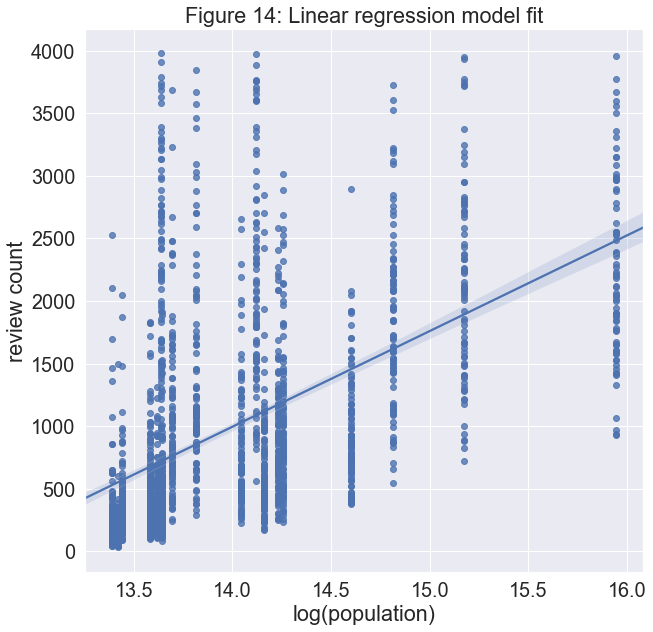

In [828]:
sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=1.8)

sns.set_style('darkgrid')
sns.regplot(x="population", y="review_count", data=results).set(title = "Figure 14: Linear regression model fit",
                                                         xlabel = "log(population)", ylabel = "review count")

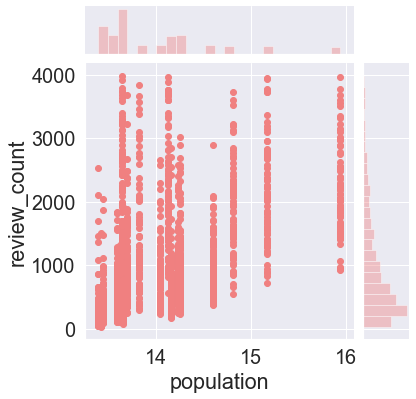

In [829]:
sns.jointplot(x = "population", y = "review_count", data = results, color="lightcoral")

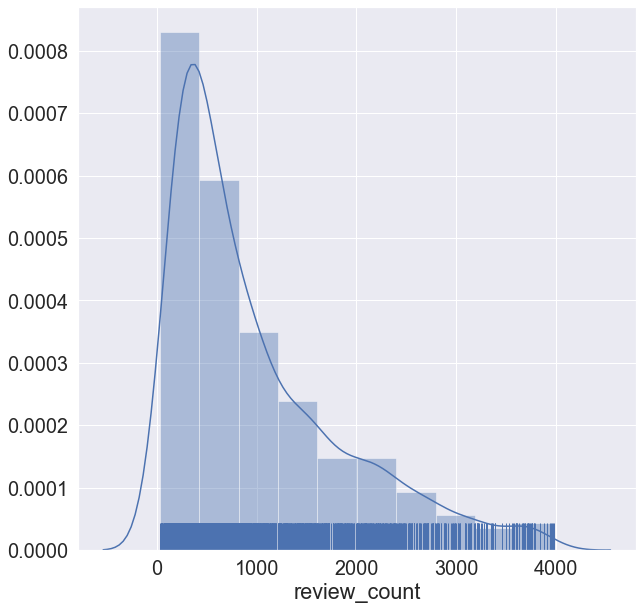

In [830]:
sns.distplot(results['review_count'], bins=10, kde=True, rug=True);

/Users/zihe/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


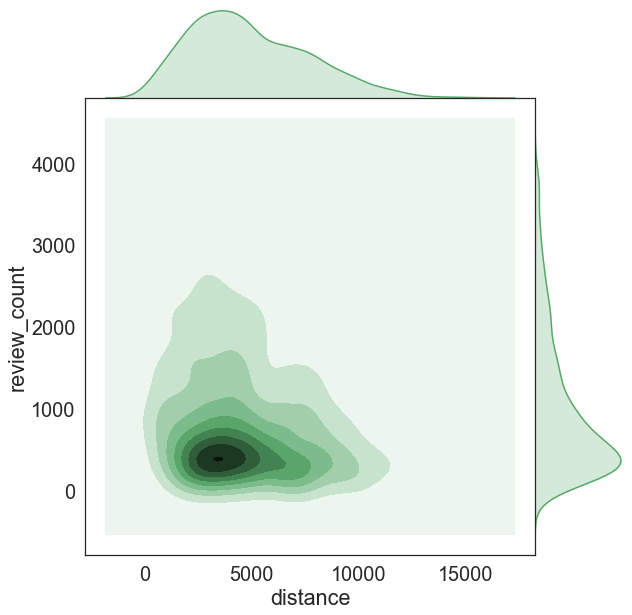

In [831]:

with sns.axes_style('white'):
    sns.jointplot(x='distance', y='review_count', data=results, kind='kde', color='g', space=0, size=(9))
    
    
#plt.title('Figure 15: Relationshiip between review count and distance')
#plt.xlabel("distance (meters)")
#plt.ylabel("review count")
                                                     

[Text(0, 0.5, 'review count'),
 Text(0.5, 0, 'price'),
 Text(0.5, 1.0, 'Figure 16: Relatipnship between price and review count')]

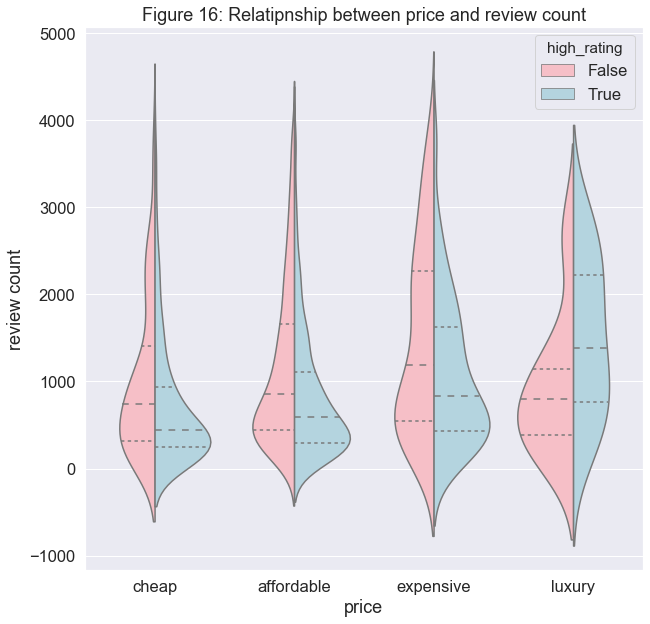

In [832]:

sns.set(font_scale=1.5)

sns.violinplot("price", "review_count", hue="high_rating", data=results, 
               split=True, inner="quartile", 
               palette=["lightpink", "lightblue"], 
               order=['cheap', 'affordable', 'expensive', 'luxury']
              ).set(title = 'Figure 16: Relatipnship between price and review count', 
                xlabel = 'price', ylabel = 'review count') 

In [834]:
# sns.pairplot(results)

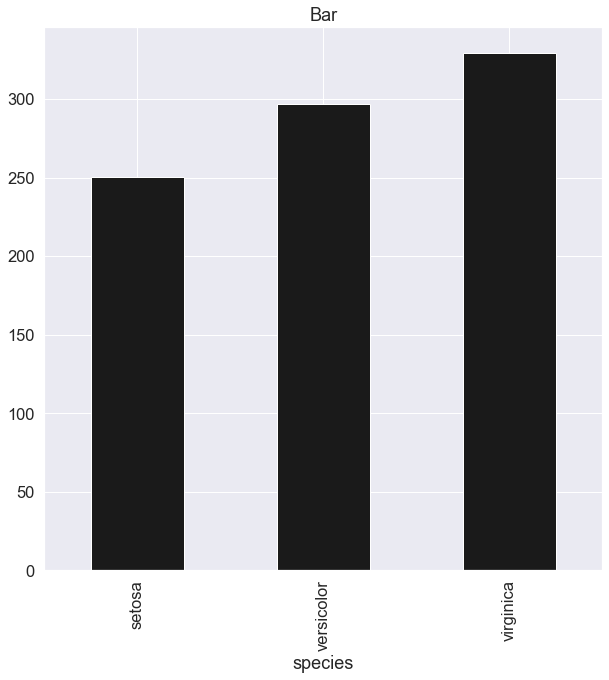

In [835]:
iris = sns.load_dataset("iris")
iris.groupby('species')['sepal_length'].sum().plot(kind='bar',
                                                   title='Bar',
                                                   color='k')


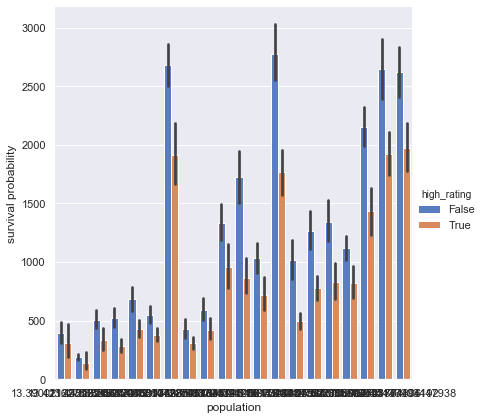

In [836]:
#sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(20,20)})
# Load the example Titanic dataset
titanic = sns.load_dataset("titanic")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="population", y="review_count", hue="high_rating", data=results,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

In [837]:
results.shape

(1904, 12)

In [838]:
results.head()

,latitude,longitude,distance,city,state,price,rating,review_count,category,subcategory,population,high_rating
4,40.742555,-74.006084,4244.358699,New York,NY,cheap,4.5,2967,mexican,Tacos,15.944437,True
5,40.722909,-73.994486,1941.963817,New York,NY,cheap,4.5,3560,restaurants,Pizza,15.944437,True
7,40.752268,-73.991086,5213.531501,New York,NY,cheap,4.5,3309,food,Bagels,15.944437,True
9,40.739020,-73.990650,3744.570400,New York,NY,affordable,4.5,3355,restaurants,Thai,15.944437,True
10,40.738440,-73.988250,3702.807580,New York,NY,luxury,4.5,2897,restaurants,American (New),15.944437,True


# Modeling

In [843]:
data = results[['latitude', 'longitude', 'distance', 'city', 'state', 'price', 'review_count', 'category', 'subcategory', 'population', 'high_rating']]

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

categorical_attr = ['city', 'state', 'price', 'category', 'subcategory']
# encode categorical variables
label_encoder = LabelEncoder()
data[categorical_attr] = data[categorical_attr].apply(label_encoder.fit_transform)
# scale continuous variables based its min and max values
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])

/Users/zihe/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/zihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/zihe/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [844]:
data.head()

,latitude,longitude,distance,city,state,price,review_count,category,subcategory,population,high_rating
4,0.869525,0.999002,0.271827,0.684211,0.636364,0.333333,0.744045,0.736842,0.900709,1.0,1.0
5,0.868019,0.999241,0.121313,0.684211,0.636364,0.333333,0.894323,0.947368,0.702128,1.0,1.0
7,0.870269,0.999311,0.335185,0.684211,0.636364,0.333333,0.830715,0.421053,0.035461,1.0,1.0
9,0.869254,0.999320,0.239155,0.684211,0.636364,0.000000,0.842372,0.947368,0.936170,1.0,1.0
10,0.869209,0.999369,0.236425,0.684211,0.636364,1.000000,0.726305,0.947368,0.000000,1.0,1.0


In [916]:
# Algorithms
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [917]:
X = data.drop(['high_rating'], axis=1).values
y = data['high_rating'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)


In [918]:
Y_train = y_train 
Y_test = y_test 

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)


decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)


In [919]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.70434783 0.72173913 0.72173913 0.65789474 0.66666667 0.70175439
 0.57017544 0.69298246 0.62280702 0.6460177 ]
Mean: 0.6706124487825952
Standard Deviation: 0.04581631990002195


7.3 Find better hyper parameters
This part will try to find better hyper-parameters for each model using GridSearchCV

In [944]:
sns.set(font_scale=1.5)
def build_train_predict(clf,X_train,y_train,X_test,strAlg,acc_score, fig_number):
    '''
    1. Create model
    2. Train model
    3. Prediction
    4. Evaluate
    5. Keep score
    '''
    model = clf
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    plot_score(y_test,pred,strAlg,acc_score, fig_number)
    return clf,pred

# create function to plot score for later use
def plot_score(y_test,y_pred,strAlg,lstScore, fig_number):
    '''
    1. Compare prediction versus real result and plot confusion matrix
    2. Store model accuracy score to list
    '''
    lstScore.append([strAlg,accuracy_score(y_test, y_pred)])
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, cmap='RdYlGn', fmt="d", vmax=80, vmin=300)
    plt.title('Figure {0}: Model - {1} \n\nAccuracy:{2:.3f}'.format(fig_number, strAlg,accuracy_score(y_test, y_pred)))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

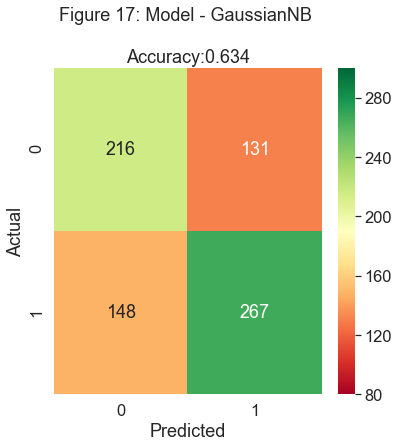

In [945]:
# import library to evaluate model
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

acc_score = []
from sklearn.naive_bayes import GaussianNB
fig_number = "17"
model_gnb,pred_gnb = build_train_predict(GaussianNB(),
                                       X_train,y_train,X_test,
                                       'GaussianNB',acc_score, fig_number)

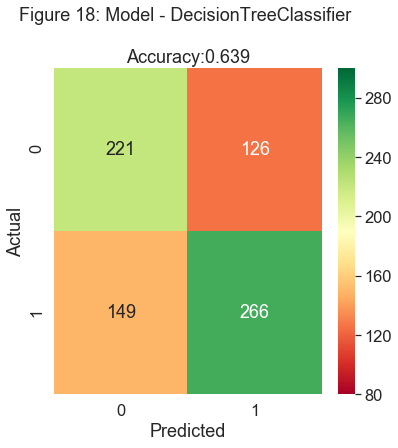

In [947]:
fig_number = "18"
model_dt,pred_dt = build_train_predict(DecisionTreeClassifier(),
                                       X_train,y_train,X_test,
                                       'DecisionTreeClassifier',acc_score, fig_number)

/Users/zihe/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


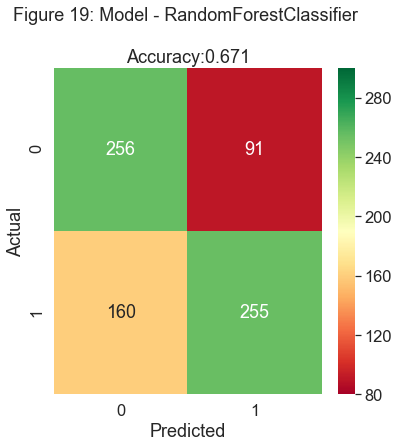

In [948]:
fig_number = "19"
model_rfc,pred_rfc = build_train_predict(RandomForestClassifier(),
                                       X_train,y_train,X_test,
                                       'RandomForestClassifier',acc_score, fig_number)

In [950]:
# See the summary, which model is leading
df_acc = pd.DataFrame(acc_score,columns=['Model','Accuracy']).sort_values(by=['Accuracy','Model'],ascending=False)
df_acc



,Model,Accuracy
2,RandomForestClassifier,0.670604
1,DecisionTreeClassifier,0.639108
0,GaussianNB,0.633858


In [ ]:
7.2 Cross validation
Accuracy obtain from train dataset can be bias since some extreme observation may not exist in train dataset and lead to bad prediction when facing test dataset. cross-validation with Kfold would help on this issue. The score from cross validated model would be more reliable

This part will not be added to accuracy summmary table

In [951]:
from sklearn.model_selection import cross_val_score

#create function to store
def cross_val_MinMaxMean(clf,X_train,y_train,fold):
    scores = cross_val_score(clf,X_train,y_train,cv=fold)
    print('Min: {} \nMax: {} \nMean: {}'.format(scores.min(),scores.max(),scores.mean()))
    
    
#cross_val_MinMaxMean(LogisticRegression(),X_train,y_train,10)
#cross_val_MinMaxMean(GaussianNB(),X_train,y_train,10)
#cross_val_MinMaxMean(RandomForestClassifier(),X_train,y_train,10)

In [952]:
# #import library for model improvement
# from sklearn.model_selection import GridSearchCV

# # function to reduce coding
# def wrap_gridsearchCV(clf,X_train,y_train,X_test,param_grid,strAlg,acc_score):
#     '''
#     1. Create GridSearch model
#     2. Train model
#     3. Predict
#     4. Evaluate
#     5. Keep score
#     '''
#     model = GridSearchCV(estimator=clf,param_grid=param_grid,cv=10,
#                          refit=True,verbose=0,n_jobs=-1)
#     model.fit(X_train,y_train)
#     print('\nBest hyper-parameter: {} \n'.format(model.best_params_))
#     pred = model.predict(X_test)
#     plot_score(y_test,pred,strAlg,acc_score)
#     return model,pred


# param_grid = {
#     'n_estimators': [i for i in range(100,1000,100)],
#     'max_depth': [i for i in range(5,10)],
#     'min_samples_leaf': [2,3,4,5]
# }
# model_grid_rfc,pred_grid_rfc = wrap_gridsearchCV(RandomForestClassifier(),
#                                                X_train,y_train,X_test,
#                                                param_grid,
#                                                'RandomForestClassifier GCV',acc_score)



In [953]:
dt_fi = model_dt.feature_importances_
rfc_fi = model_rfc.feature_importances_

fi = [dt_fi,rfc_fi]
model_name = ['DecisionTree','RandomForrest']
model_name = pd.Series(model_name)
df_fi = pd.DataFrame(fi,columns=data.drop(['high_rating'], axis=1).columns)
df_fi.index = model_name
df_fi

,latitude,longitude,distance,city,state,price,review_count,category,subcategory,population
DecisionTree,0.150824,0.105223,0.175202,0.018685,0.01034,0.036021,0.297471,0.020180,0.099748,0.086305
RandomForrest,0.148367,0.153415,0.137023,0.040450,0.03101,0.041529,0.236452,0.037267,0.108066,0.066420


/Users/zihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


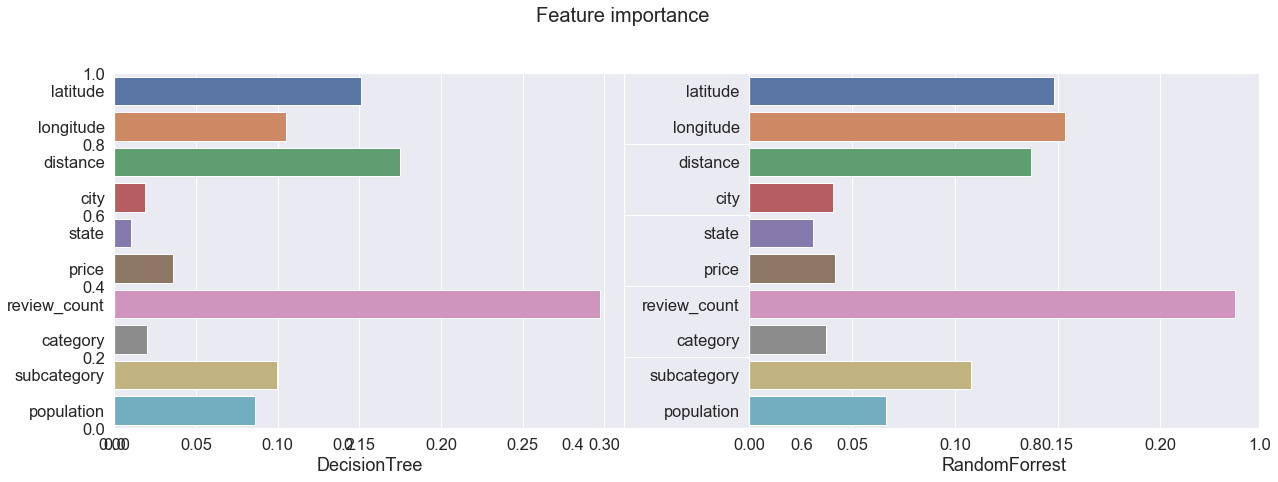

In [970]:
#set overall size
fig = plt.figure(figsize=(20,8))
#set total number of rows and columns
row = 1
col = 2
#set title
fig.suptitle('Feature importance',fontsize=20)

# boxes
for index,i in enumerate(df_fi.index):
    fig.add_subplot()
    ax = fig.add_subplot(row,col,index+1)
    sns.barplot(df_fi.loc[i],df_fi.columns)
    

#some more setting
plt.tight_layout(pad=4,w_pad=1,h_pad=1.5)
plt.show()